In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import sklearn.metrics as metrics

In [4]:
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Función para limpiar el texto
def limpiar_html(review):
    limpio = BeautifulSoup(review, "html.parser")
    return limpio.get_text()

In [7]:
# Elimino las etiquetas html de los reviews
df['review'] = df['review'].apply(limpiar_html)

In [8]:
# Codifico las clasificaciones
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0)

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [11]:
# Verifico si la columna 'review' tiene valores nulos o vacíos
valores_nulos = df['review'].isna().sum()

if valores_nulos > 0:
    print(f"La columna 'review' tiene {valores_nulos} valores nulos o vacíos.")
else:
    print("La columna 'review' no tiene valores nulos o vacíos.")

La columna 'review' no tiene valores nulos o vacíos.


In [12]:
# Verifico si la columna 'review' tiene valores nulos o vacíos
valores_nulos = df['sentiment'].isna().sum()

if valores_nulos > 0:
    print(f"La columna 'sentiment' tiene {valores_nulos} valores nulos o vacíos.")
else:
    print("La columna 'sentiment' no tiene valores nulos o vacíos.")

La columna 'sentiment' no tiene valores nulos o vacíos.


In [13]:
# Contabilizo los duplicados en la columna 'review'
review_duplicados = df['review'].duplicated().sum()

# Muestro los resultados
print(f"Cantidad de duplicados en la columna 'review': {review_duplicados}")

Cantidad de duplicados en la columna 'review': 419


In [14]:
# Elimino duplicados en la columna 'review' y mantengo solo la primera ocurrencia
df = df.drop_duplicates(subset='review', keep='first')

In [15]:
review_duplicados = df['review'].duplicated().sum()
# Muestro resultados
print(f"Cantidad de duplicados en la columna 'review': {review_duplicados}")

Cantidad de duplicados en la columna 'review': 0


In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<Axes: xlabel='sentiment'>

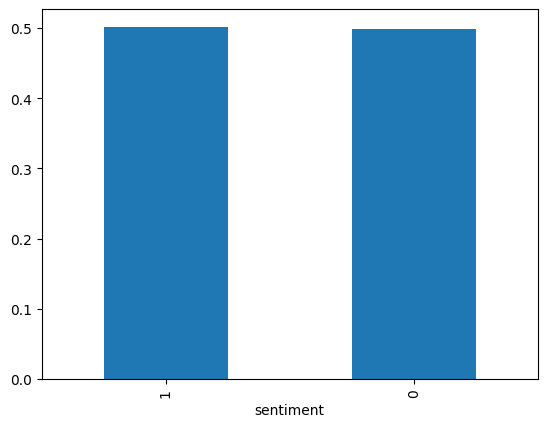

In [18]:
values = df['sentiment'].value_counts(normalize=True)
values.plot(kind='bar')

**Dataset balanceado** 

# Procedimiento de evaluación

In [20]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Pre - procesamiento para Bert

In [22]:
import numpy as np
import torch
import transformers

from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

c:\Users\lauta\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

ids_list = []       # Guardaremos los ids 
attention_mask_list = []    # los tokens que importan (mascara de atencion)

max_length = 512

for input_text in df['review']:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0]*(max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list.append(padded)
    attention_mask_list.append(attention_mask)

c:\Users\lauta\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lauta\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


KeyboardInterrupt: 

# Obtener Insertados 

In [ ]:
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
batch_size = 100   # por lo general, el tamaño del lote es igual a 100, pero lo podemos configurar en valores más bajos para reducir los requisitos de memoria

embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Uso del dispositivo {device}.')
model.to(device)

for i in tqdm(range(len(ids_list) // batch_size)):
    
    ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.eval()
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

In [ ]:
features = np.concatenate(embeddings) # Guardamos los features para el entrenamiento 
target = df['sentiment']
print(features.shape)
print(target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_bert.npz', train_features=features, target = target)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features']
#     test_features_9 = data['target']

# Modelo de clasificacion 

In [ ]:
features_train,features_test, target_train, target_test = train_test_split(features,target, test_size = 0.5, random_state = 54321)
model = LogisticRegression(solver = 'liblinear')
model.fit(features_train,target_train)
predictions = model.predict(features_test)

In [ ]:
evaluate_model(model, features_train, target_train, features_test, target_test)